# Evaluamos el filtrado de Rainview Analyzer

Se evaluará el comportamiento del cluttermap basado en la sustracción de valores que propone como primera alternativa Rainview Analyzer. Se basa la selección de un cluttermap durante "precipitation free conditions",elaborado por composición estadística(media,moda,máximos,mínimos,etc). Vea el Manual de Usuario para más detalles.

In [2]:
from pathlib import Path
import wradlib as wrl
import matplotlib.pyplot as plt
import numpy as np
import skimage
import warnings 

import Bases_GUI as radar
import utilidades as util

from skimage.morphology import disk

warnings.filterwarnings('ignore')

Importamos los datos de clutter para elaborar la composición.

In [3]:
ruta = 'C:\Python37\Clutter'
clutterdata = util.dataclass(ruta)
Matriz = util.matriz3d(clutterdata)
azi, r = util.ejes()

Clutter_min = np.min(Matriz, axis=2)
Clutter_max = np.max(Matriz, axis=2)
Clutter_mean = np.mean(Matriz, axis=2)
Clutter_median = np.median(Matriz, axis=2)

El manual recomienda por defecto utilizar los valores máximos. 

Para representar el efecto del clutter spread (selección del máximo valor dentro de una zona determinada) puede ser puesto a cero en cuyo caso toma el valor de cada dato. Si es diferente se selecciona el mayor valor dentro de una zona circular del radio especificado. Este enfoque ciertamente parece imparcial, pero si se recuerda los datos son polares y cerca al radar ocupan muy poca área, en ese caso se enmascararía el comportamiento de toda la zona cercana bajo un solo valor lo cual visto de ese modo no resulta tan imparcial. 

En su lugar usaremos una ventana de 3x3, que si bien cambia de tamaño real a medida que recorremos el eje radial, proporcionará mejores representaciones para los valores pequeños y que dada la distribución espacial del clutter son aquellos que más nos interesan. 

A modo de comentario, existe una manera más de representar ese comportamiento: a través de un remuestreo de los datos sobre una cuadricula cartesiana. Dado que este tema involucra interpolación de los datos, aún no será abordado. 

In [4]:
def maximum(Matriz, selem):
    # Escalamos los datos originales hacia 0. y 1.
    tmp = Matriz.copy()
    cvalue = -31.5
    range = (31.5 + tmp.max())
    tmp = (tmp - cvalue)/ range
    # Máximo local
    result = skimage.filters.rank.maximum(tmp, selem=selem)
    # Regresamos al espacio original
    result = skimage.img_as_float(result)
    result = (result * range) + cvalue
    return result

In [5]:
selem = np.ones(shape=(3,3))
local_max = maximum(Clutter_max, selem)

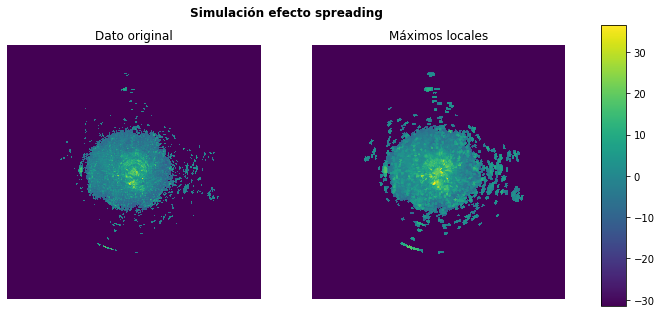

In [6]:
fig = plt.figure(figsize=(10, 5))    
tmp = plt.title('Simulación efecto spreading', fontweight='bold')
tmp.set_y(1.05)
plt.axis('off')

ax = fig.add_subplot(121)
ax, pm = wrl.vis.plot_ppi(Clutter_max, r=r, az=azi, ax=ax)    
ax = util.complement_ax(ax, rmax=20)
ax.set_title('Dato original')
ax.axis('off')

ax = fig.add_subplot(122)
ax, pm = wrl.vis.plot_ppi(local_max, r=r, az=azi, ax=ax)    
ax = util.complement_ax(ax, rmax=20)
ax.set_title('Máximos locales')
ax.axis('off')

cax = plt.axes([0.95, 0.13, 0.035, 0.78])
fig.colorbar(pm, cax=cax)

Es posible apreciar la clusterización en torno a los máximos locales. 

El método también usa un factor de ajuste aditivo para aumentar/disminuir la tasa de clutter. En este cuaderno lo denominaremos Cadj

In [7]:
Cadj = 1 

In [8]:
Cluttermap = local_max + Cadj

La mitigación del clutter se realiza a través de un proceso de substracción en reflectividad(Z) y no en reflectividad logaritmica(dBZ). 

In [9]:
def mitigation(data, Cluttermap, mask=False):
    data_z = wrl.trafo.idecibel(data)
    clutter_z = wrl.trafo.idecibel(Cluttermap)
    data_corr = data_z - clutter_z
    data_corr_dbz = wrl.trafo.decibel(data_corr)
    if mask:
        binimg = data_corr_dbz > -31.5
        data_corr_dbz[~binimg] = -31.5
    return data_corr_dbz

Para evaluar este procedimiento usaremos los datos de ejemplo ya vistos.

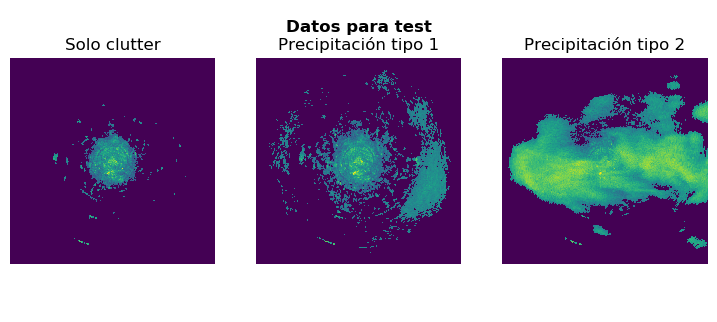

In [10]:
datos, titles = util.testeo(explore=True)

In [11]:
application = []
for dato in datos: 
    application.append(mitigation(dato,Cluttermap))

Mostramos los resultados:

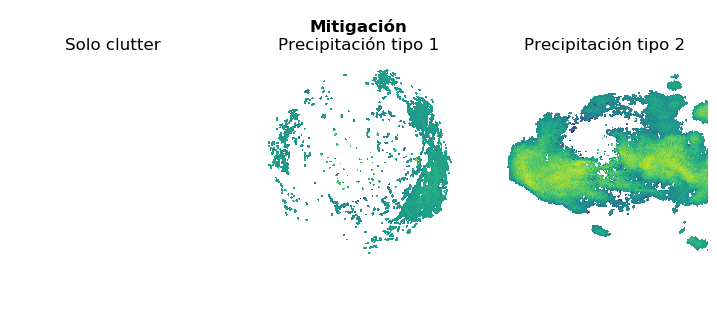

In [12]:
util.testeo_results(cluttermaps=None, results=application, rmax=15, title2='Mitigación')

Para el ejemplo de "Solo clutter", se logro un filtrado muy bueno porque se ha usado el valor máximo de clutter para el filtrado. En el segundo caso, quedan muchas zonas residuales por filtrar de pequeño tamaño, por lo que el algoritmo no se ha 
desempeñado lo suficientemente bien para estos datos(al menos por si solo). En contraste para el tercer caso los resultados eliminan la textura mencionada en cuadernos, sin embargo crea pequeñas zonas dentro de los datos que presentan baja correlación espacial con el resto de datos(huecos).

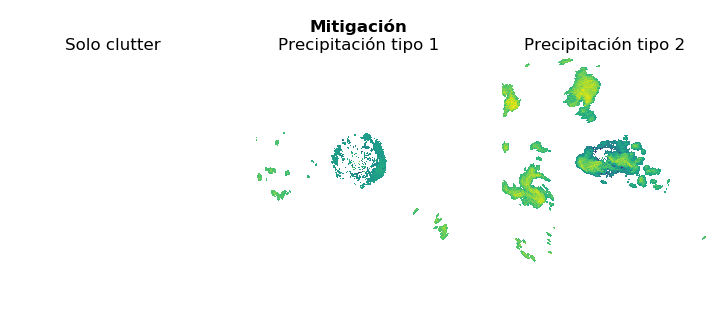

In [13]:
util.testeo_results(cluttermaps=None, results=application, rmax=50, title2='Mitigación')

Las precipitaciones en las lejanías se conservan bastante bien. 

Si queremos que como en los anteriores ejemplos el fondo regrese al valor de reflectividad mínimo podemos enmascarar esos datos. En los casos anteriores estos correspondían a -Inf o NaN y no podían graficarse(por ello salían en blanco).

In [14]:
application = []
for dato in datos: 
    application.append(mitigation(dato, Cluttermap, mask=True))

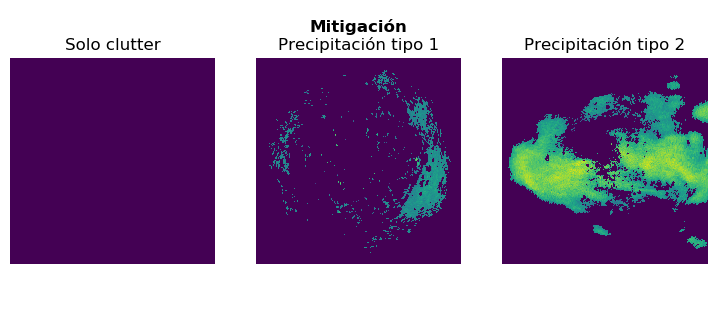

In [15]:
util.testeo_results(cluttermaps=None, results=application, rmax=15, title2='Mitigación')

Reitero, este no es el procedimiento usado por Rainview Analyzer pues la agrupación de máximos locales es mucho mayor durante la primera etapa. A continuación se ilustrará el efecto usando la estrategia utilizada. Para ello proyectaremos los datos en una grilla rectangular de 100m x 100m. La interpolación usada será Vecino Más cercano que para este caso sirve apropiadamente pues se conservarán los valores de reflectividad como tal. Este no es el caso de los datos para visualización, así que no debería ser aplicable en ese escenario. 

Para ello necesitaremos usar las coordenadas del radar y su ángulo de elevación, así como cambiar las unidades del rango a metros.

In [16]:
radar_location = (-80.638333,-5.170278,56)
elevation = 2
alcance = 100000
rectgrilla = 100
azi,r = util.ejes()
r = r * 1000
res = 2*alcance/rectgrilla

In [17]:
polargrid = np.meshgrid(r, azi)
coords, rad = wrl.georef.spherical_to_xyz(polargrid[0], polargrid[1],elevation, radar_location)
x = coords[..., 0]
y = coords[..., 1]

In [18]:
xgrid = np.linspace(x.min(), x.max(), res)
ygrid = np.linspace(y.min(), y.max(), res)
grid_xy = np.meshgrid(xgrid, ygrid)
grid_xy = np.vstack((grid_xy[0].ravel(), grid_xy[1].ravel())).transpose()
xy=np.concatenate([x.ravel()[:,None],y.ravel()[:,None]], axis=1)
gridded = wrl.comp.togrid(src=xy, trg=grid_xy, radius=100000., center=np.array([x.mean(), y.mean()]),
                          data=Clutter_max.ravel(), interpol=wrl.ipol.Nearest)
gridded = np.ma.masked_invalid(gridded).reshape((len(xgrid), len(ygrid)))

Veremos el resultado de la proyección.

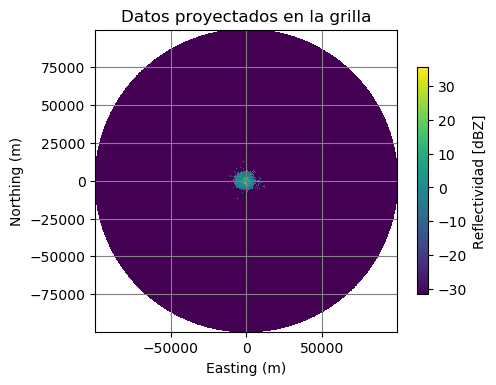

In [19]:
fig = plt.figure(figsize=(5,4), dpi=100)
ax = plt.subplot(111, aspect="equal")
pm = plt.pcolormesh(xgrid, ygrid, gridded)
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados en la grilla')
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
n = 1/10
plt.xlim(min(xgrid), max(xgrid))
plt.ylim(min(ygrid), max(ygrid))
plt.grid(color="grey")

Nos acercaremos a la región central para ver el clutter.

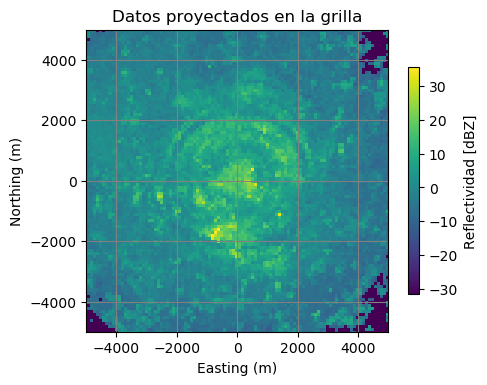

In [20]:
fig = plt.figure(figsize=(5,4), dpi=100)
ax = plt.subplot(111, aspect="equal")
pm = plt.pcolormesh(xgrid, ygrid, gridded)
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados en la grilla')
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.xlim(min(xgrid) / 20, max(xgrid) / 20)
plt.ylim(min(ygrid) / 20, max(ygrid) / 20)
plt.grid(color="grey")

Con los datos proyectados es posible realizar el proceso de selección por áreas de manera sencilla. Para ello usaremos un disco de 2km de radio.

In [21]:
disco = disk(20)
local_maxc = maximum(gridded,disco) 

(-9979.29903121829, 9979.29903121829)

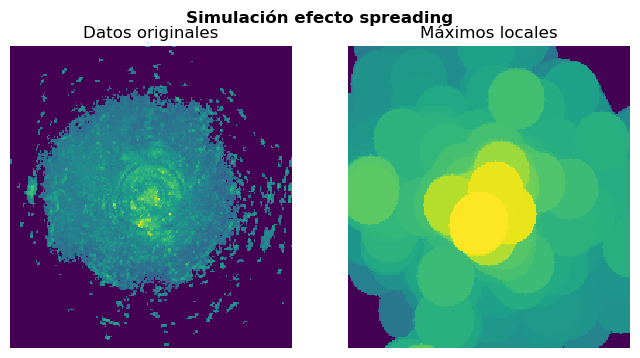

In [22]:
fig = plt.figure(figsize=(8,4), dpi=100)
tmp = plt.title('Simulación efecto spreading', fontweight='bold')
tmp.set_y(1.05)
plt.axis('off')
n = 1/10

ax = fig.add_subplot(121)
pm = plt.pcolormesh(xgrid, ygrid, gridded)
ax.set_title('Datos originales')
ax.axis('off')
ax.set_xlim(n * min(xgrid), n * max(xgrid))
ax.set_ylim(n * min(ygrid), n * max(ygrid))

ax = fig.add_subplot(122)
pm = plt.pcolormesh(xgrid, ygrid, local_maxc)
ax.set_title('Máximos locales')
ax.axis('off')
ax.set_xlim(n * min(xgrid), n * max(xgrid))
ax.set_ylim(n * min(ygrid), n * max(ygrid))


Vemos como tomar en cuenta el efecto de clutter spreading solo disminuye la calidad de los datos originales. 

Una vez hecho esto deberíamos regresar los datos hacia su formato original. Pero ya se observa que el resultado no será bueno. Este tipo de efecto resulta muy útil para filtrar si encontrasemos clutter en las lejanías del radar, pero como no es así es mejor dejarlo de lado.

El factor de ajuste Cadj puede ser positivo o negativo, al ser positivo filtramos más y la sustracción es mayor; en cambio si es negativo filtraremos menos. Tal vez el valor de 1 dBZ pueda parecer poca cosa pero estamos hablando de valores logaritmicos y un pequeño puede representar un cambio drámatico. Para valores de 4.5 dBZ dependiendo de que relación Z-R usamos, la tasa de precipitación puede disminuir a la mitad. 

El software tambien proporciona posibilidades de interpolar algunos valores, por lo que en el siguiente cuaderno nos centraremos en abordar esa posibilidad y sus implicaciones.